# Challenge 2: Recommendation Engine for Prime Video

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
% load_ext autoreload
% autoreload 2

# Load Data

In [2]:
# Load video counts. Sort by video ID & date
video_data = pd.read_csv('data/challenge_2/video_count.csv')
video_data = video_data.sort_values(by=['video_id', 'date'])
video_data = video_data.reset_index(drop=True)
print(video_data.shape)

# Load video features. Sort by video ID
video_features = pd.read_csv('data/challenge_2/video_features.csv')
video_features = video_features.sort_values(by=['video_id'])
video_features = video_features.reset_index(drop=True)
print(video_features.shape)

print('\n')
print(video_data.head(3))
print('\n')
print(video_features.head(3))

(41775, 3)
(2785, 5)


   video_id  counts        date
0         1  140460  2015-01-01
1         1  129082  2015-01-02
2         1  120868  2015-01-03


   video_id  video_length video_language video_upload_date video_quality
0         1          1496             Es        2014-12-04          720p
1         2           751             Cn        2014-12-14          480p
2         3           807             En        2014-12-15         1080p


### Data Information

In [3]:
total_samples = video_data.counts.shape[0]
num_days = np.unique(video_data['date']).shape[0]
num_vids = int(total_samples / num_days)

print('%d total samples' % total_samples)
print('%d different days' % num_days)
print('%d different videos' % num_vids)

41775 total samples
15 different days
2785 different videos


## Group counts to video_id

In [4]:
counts = np.zeros((num_vids, num_days))
video_id = np.zeros((num_vids, 1))

for vid_id in range(num_vids):
    counts[vid_id, :] = video_data['counts'][(vid_id*num_days) : (vid_id+1)*num_days]
    video_id[vid_id, 0] = video_data['video_id'][(vid_id*num_days)]
    
print('Video counts: ', counts.shape)
print('    Video ID: ', video_id.shape)

Video counts:  (2785, 15)
    Video ID:  (2785, 1)


## Normalise data

In [5]:
counts_norm = np.zeros(counts.shape)

for i in range(num_vids):
    counts_norm[i,:] = counts[i,:] / counts[i,0]
    
print('Normalised data shape: ', counts_norm.shape)

Normalised data shape:  (2785, 15)


# Clustering

## Classify 'Hot' Videos

Hot videos means trending upwards. These videos are candidates to be shown and are characterised by a large increase in the normalised view count (which is normalised to the `video_id` count at the beginning of the investigation period).

In [6]:
from sklearn.cluster import KMeans

kmeans1 = KMeans(n_clusters=2, tol=1e2, init='random', random_state=0).fit(counts_norm)
dict1 = {i: np.where(kmeans1.labels_ == i)[0] for i in range(kmeans1.n_clusters)}

In [7]:
if np.mean(counts_norm[dict1[0]]) > np.mean(counts_norm[dict1[1]]):
    hot_idx = dict1[0]
    other_idx = dict1[1]
    labels1 = ['Hot', 'Other']
else:
    hot_idx = dict1[1]
    other_idx = dict1[0]
    labels1 = ['Other', 'Hot']

print('"Hot" videos: ', hot_idx.shape[0])
print('Other videos: ', other_idx.shape[0])

"Hot" videos:  463
Other videos:  2322


Hot:          Average Normalised Count: 30.25          Average Daily Count: 85810
Other:          Average Normalised Count:  0.87          Average Daily Count: 731759


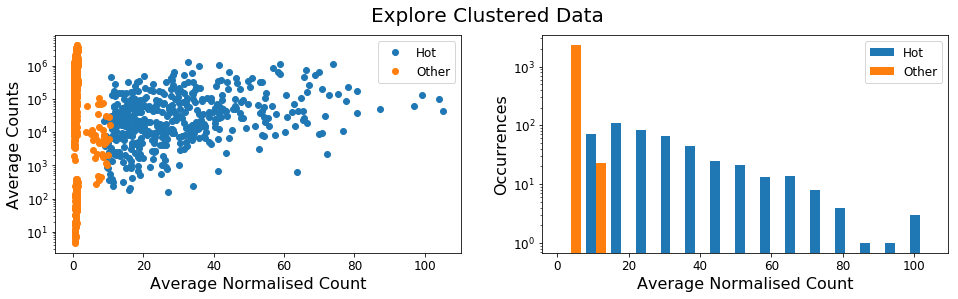

In [8]:
from utils.utils import*

plot1(kmeans1, counts, counts_norm, dict1, labels1)

## Classify Stable & Popular vs. Everything Else

Popular videos are stable in the sense that their view counts are flat, but very high. Their normalised view count (normalised to the view count at the beginning of the investigation period) is approximately 1.00, indicating the view counts are flat. These videos are candidates to be shown and are characterised by large absolute view counts.

In [9]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(counts[other_idx])
dict2 = {i: np.where(kmeans2.labels_ == i)[0] for i in range(kmeans2.n_clusters)}

In [10]:
if np.mean(counts[other_idx][dict2[0]]) > np.mean(counts[other_idx][dict2[1]]):
    popular_idx = dict2[0]
    else_idx = dict2[1]
    labels2 = ['Popular', 'Else']
else:
    popular_idx = dict2[1]
    else_idx = dict2[0]
    labels2 = ['Else', 'Popular']

print('"Popular" videos: ', popular_idx.shape[0])
print('Everything Else: ', else_idx.shape[0])

"Popular" videos:  509
Everything Else:  1813


Else:          Average Normalised Count:  0.83          Average Daily Count: 305828
Popular:          Average Normalised Count:  1.01          Average Daily Count: 2248874


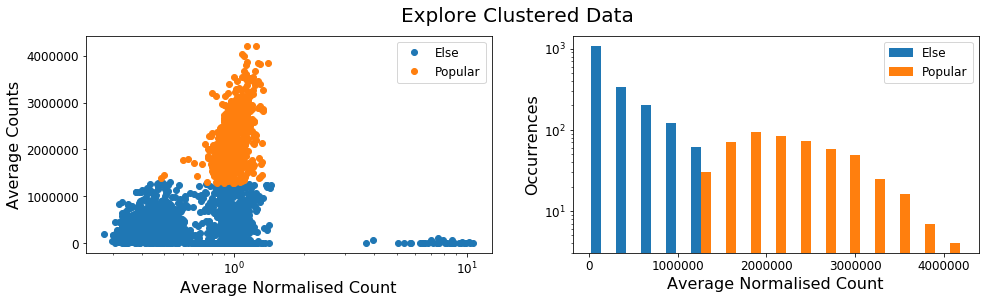

In [11]:
from utils.utils import*
plot2(kmeans2, counts[other_idx], counts_norm[other_idx], dict2, labels2)

# Classifications

## Save classifications & print some to screen

In [12]:
## Hot videos
np.savetxt('results/Q2/Hot_Video_ID.csv', video_id[hot_idx])
video_id[hot_idx][:5]

array([[10.],
       [13.],
       [15.],
       [28.],
       [49.]])

In [13]:
## Stable & Popular videos
np.savetxt('results/Q2/Popular_Video_ID.csv', video_id[popular_idx])
video_id[popular_idx][:5]

array([[ 2.],
       [ 3.],
       [ 4.],
       [ 8.],
       [12.]])

In [14]:
## Everything Else
np.savetxt('results/Q2/Else_Video_ID.csv', video_id[else_idx])
video_id[else_idx][:5]

array([[1.],
       [5.],
       [6.],
       [7.],
       [9.]])

## Characteristics of "Hot" Videos

In [15]:
all_idx = np.arange(num_vids)

### Video Length

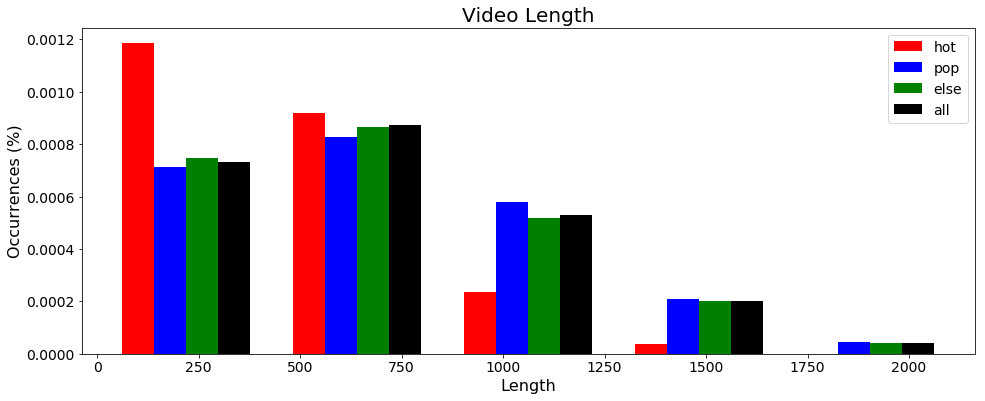

In [35]:
from utils.utils import *
plot_video_length(video_features['video_length'], hot_idx, popular_idx, else_idx, all_idx)

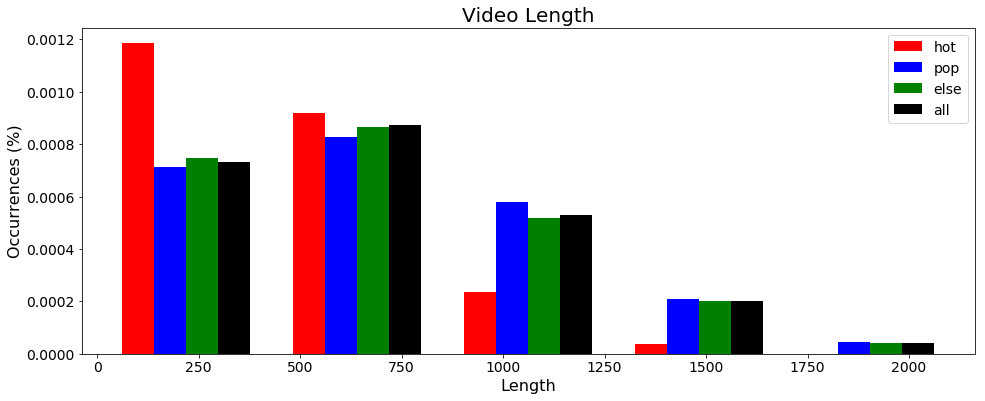

In [38]:
series1 = video_features['video_length'][hot_idx]
series2 = video_features['video_length'][popular_idx]
series3 = video_features['video_length'][else_idx]
series4 = video_features['video_length'][all_idx]
series = [series1, series2, series3, series4]
labels = ['hot', 'pop', 'else', 'all']
colors = ['red', 'blue', 'green', 'black']

plt.figure(figsize=(16,6))
plt.title('Video Length', fontsize=20)
plt.xlabel('Length', fontsize=16)
plt.ylabel('Occurrences (%)', fontsize=16)
    
plt.hist(series, bins=5, histtype='bar', align='mid', rwidth=0.75, density=True, color=colors, label=labels)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.show()

In [ ]:
from utils.utils import *

plot_video_language(video_features['video_length'], hot_idx, popular_idx, else_idx, all_idx)

### Video Language

In [ ]:
from utils.utils import *

plot_video_language(video_features['video_language'], hot_idx, popular_idx, else_idx, all_idx)

### Video Upload Date

In [ ]:
from utils.utils import*

plot_video_date(video_features['video_upload_date'], hot_idx, popular_idx, else_idx, all_idx)

### Video Quality

In [ ]:
from utils.utils import*

plot_video_quality(video_features['video_quality'], hot_idx, popular_idx, else_idx, all_idx)